# *Proyecto de Deep Learning*
---

##  *Enfoque clasificacion Binaria*

 ### 📌 ***Objetivos:***

*Desarrollar un modelo de Deep Learning multimodal capaz de clasificar puntos de interés (POIs) turísticos según su nivel de engagement en dos categorías: alto o bajo.*

***Propósito específico***:
- *Integrar información visual (imágenes) y estructurada (metadatos) para predecir si un POI tendrá una alta interacción por parte del usuario.*
- *Establecer un pipeline de clasificación robusto, combinando redes convolucionales y redes densas.*
- *Servir como prototipo base para exploraciones más complejas (como clasificación multiclase o sistemas de recomendación).*

---



In [6]:
# Imports necesarios para el módulo / REVISAR, FALTAN
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import cv2
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import torchvision
from torchvision import datasets, transforms
from PIL import Image

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


from PIL import Image
import os
from google.colab import drive
from itertools import chain
import ast
import folium
import folium.plugins as plugins

Empezaremos nuestro proyecto explorando nuestro datos.

Los datos estan divididos en 2 partes:
* Dataset de Puntos de interes turistico
* Dataset de Imagenes

1. Uniremos los datos en un solo DataFrame
2.  Realizaremos analisis exploratorio de datos


## 1. Estructura de los datos

In [7]:
# Conectar a Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Ruta al archivo CSV con metadatos
csv_path = '/content/drive/MyDrive/Deep Learning/Proyecto/poi_dataset.csv'
df = pd.read_csv(csv_path)

# Visualizamos las primeras filas
df.head().T

,0,1,2,3,4
id,4b36a3ed-3b28-4bc7-b975-1d48b586db03,e32b3603-a94f-49df-8b31-92445a86377c,0123a69b-13ac-4b65-a5d5-71a95560cff5,390d7d9e-e972-451c-b5e4-f494af15e788,023fc1bf-a1cd-4b9f-af78-48792ab1a294
name,Galería Fran Reus,Convento de San Plácido,Instituto Geológico y Minero de España,Margarita Gil Roësset,Museo del Traje. Centro de Investigación del P...
shortDescription,La Galería Fran Reus es un espacio dedicado a ...,"El Convento de San Plácido en Madrid, fundado ...","El Instituto Geológico y Minero de España, sit...","Margarita Gil Roësset, escultora y poetisa esp...","El Museo del Traje de Madrid, fundado en 2004,..."
categories,"['Escultura', 'Pintura']","['Patrimonio', 'Historia']","['Ciencia', 'Patrimonio']",['Cultura'],"['Patrimonio', 'Cultura']"
tier,1,1,2,1,1
locationLon,2.642262,-3.704467,-3.699694,-3.691228,-3.727822
locationLat,39.572694,40.423037,40.442045,40.427256,40.439665
tags,[],[],[],[],[]
xps,500,500,250,500,500
Visits,10009,10010,10015,10011,10020


In [ ]:
print("Dimensiones de los datos:",df.shape)
print("\n Tipos de datos:", df.dtypes)

Dimensiones de los datos: (1569, 14)

 Tipos de datos: id                   object
name                 object
shortDescription     object
categories           object
tier                  int64
locationLon         float64
locationLat         float64
tags                 object
xps                   int64
Visits                int64
Likes                 int64
Dislikes              int64
Bookmarks             int64
main_image_path      object
dtype: object


La columna `['main_image_path']` nos indica la ruta relativa de cada imagen, recordemos que, estan ubicadas en carpetas individuales.

Construiremos la colunma `['image_full_path']` que nos proporciona la direccion real de nuestras imagenes al `DataFrame`

In [9]:
#Craemos ruta al directorio del proyecto
root_dir = '/content/drive/MyDrive/Deep Learning/Proyecto'

#Nueva columna con  la ruta directa
df['image_full_path'] = df['main_image_path'].apply(lambda x: os.path.join(root_dir, x.strip('/')))

#Confirmacion
print(df['image_full_path'].iloc[0])
print(os.path.exists(df['image_full_path'].iloc[0]))

/content/drive/MyDrive/Deep Learning/Proyecto/data_main/4b36a3ed-3b28-4bc7-b975-1d48b586db03/main.jpg
True


### 1.1 EDA de los datos

Realizamos un Analisis exploratorio de datos(EDA), para conocer su distribución y sus características, identificar patrones, correlaciones y posibles anomalías.


In [ ]:
print("Dimensiones de los datos:",df.shape)
print("\n Tipos de datos:", df.dtypes)

Dimensiones de los datos: (1569, 15)

 Tipos de datos: id                   object
name                 object
shortDescription     object
categories           object
tier                  int64
locationLon         float64
locationLat         float64
tags                 object
xps                   int64
Visits                int64
Likes                 int64
Dislikes              int64
Bookmarks             int64
main_image_path      object
image_full_path      object
dtype: object


In [ ]:
#valores nulos
print("Valores nulos por columna:")
print(df.isnull().sum())

Valores nulos por columna:
id                  0
name                0
shortDescription    0
categories          0
tier                0
locationLon         0
locationLat         0
tags                0
xps                 0
Visits              0
Likes               0
Dislikes            0
Bookmarks           0
main_image_path     0
image_full_path     0
dtype: int64


In [10]:
print(df['categories'].apply(lambda x: len(x.split(','))).value_counts())
# Nos indica la cantidad de etiquetas en string que tienen las filas; ejemplo:
# "['Escultura', 'Cultura', 'Historia']"-> 3 valores en -> 1073 filas

print(df['categories'].iloc[0])
print(type(df['categories'].iloc[0]))

categories
3    1073
4     325
2     106
1      65
Name: count, dtype: int64
['Escultura', 'Pintura']
<class 'str'>


In [11]:
df['categories_list'] = df['categories'].apply(lambda x: ast.literal_eval(x))

valores_unicos = set(chain.from_iterable(df['categories_list']))
print("Valores únicos:", valores_unicos)

Valores únicos: {'Patrimonio', 'Pintura', 'Misterio', 'Escultura', 'Ciencia', 'Arquitectura', 'Gastronomía', 'Ocio', 'Naturaleza', 'Cine', 'Cultura', 'Historia'}


In [ ]:
# Valores unicos
print("Valores únicos en la columna 'Tier':")
print(df['tier'].unique())
print("\nValores únicos en la columna 'Tags':")
print(df['tags'].unique())

Valores únicos en la columna 'Tier':
[1 2 3 4]

Valores únicos en la columna 'Tags':
['[]' "['s.XX']"
 "['Canaletto', 'paisaje', 'vedutismo', 's.XVIII', 'Cuadro', 'Venecia']"
 ... "['Estatuas', 'Plaza']" "['Alcalá', 'Gran Vía', 'Metrópolis']"
 "['Arquitectura', 'Cisterciense', 'Císter', 'Moreruela', 'Zamora', 'Ruinas', 'Monasterio']"]


In [ ]:
df['tier'].value_counts()

,count
tier,
1,837
2,622
3,103
4,7


<Axes: xlabel='tier', ylabel='count'>

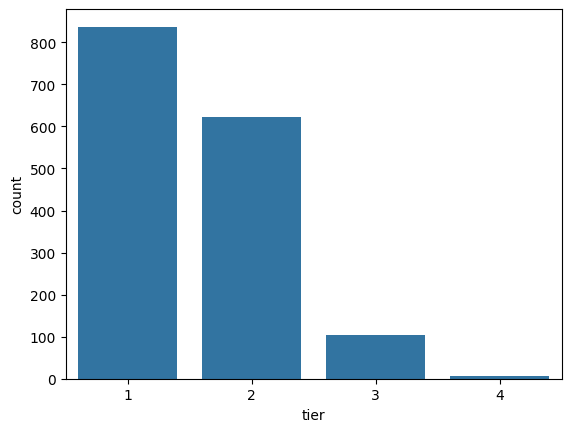

In [ ]:
sns.countplot(data=df, x='tier')

<Axes: xlabel='xps', ylabel='count'>

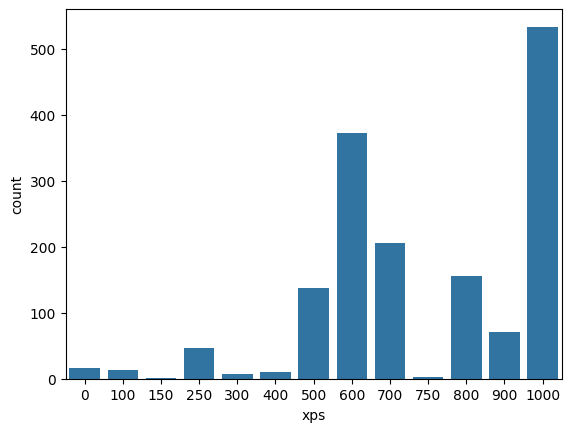

In [ ]:
sns.countplot(data=df, x='xps')

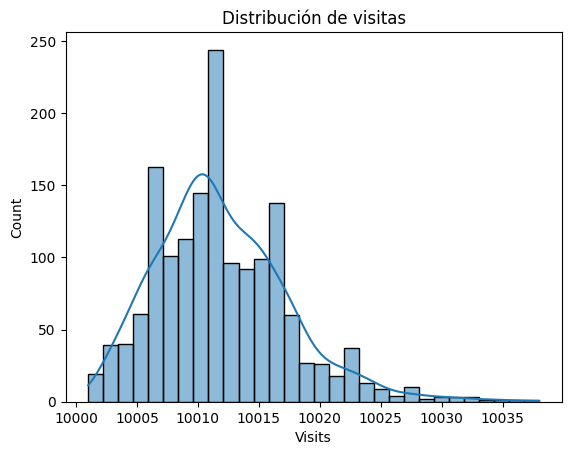

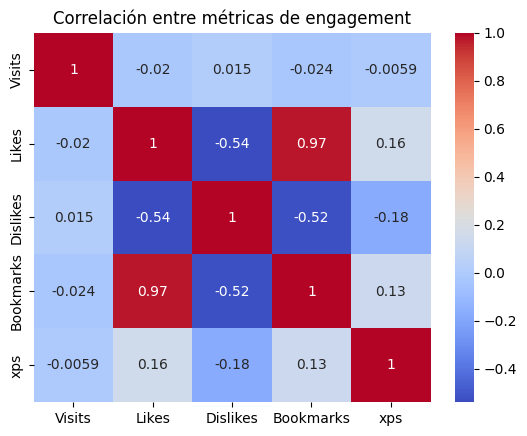

In [9]:
# Histograma de visitas
sns.histplot(df['Visits'], bins=30, kde=True)
plt.title('Distribución de visitas')
plt.show()

# Correlaciones entre métricas de engagement
cols_interes = ['Visits', 'Likes', 'Dislikes', 'Bookmarks', 'xps']
correlaciones = df[cols_interes].corr()

sns.heatmap(correlaciones, annot=True, cmap='coolwarm')
plt.title('Correlación entre métricas de engagement')
plt.show()

### 1.2 EDA de las imagenes

array([[[226, 223, 215],
        [231, 228, 220],
        [236, 233, 225],
        ...,
        [242, 238, 233],
        [242, 238, 233],
        [242, 238, 233]],

       [[191, 188, 180],
        [228, 225, 217],
        [251, 248, 240],
        ...,
        [243, 239, 234],
        [243, 239, 234],
        [243, 239, 234]],

       [[169, 166, 161],
        [203, 200, 195],
        [226, 223, 218],
        ...,
        [244, 240, 235],
        [244, 240, 235],
        [244, 240, 235]],

       ...,

       [[228, 230, 231],
        [227, 229, 230],
        [227, 229, 229],
        ...,
        [255, 253, 253],
        [255, 252, 253],
        [255, 252, 253]],

       [[229, 231, 232],
        [226, 228, 229],
        [222, 227, 226],
        ...,
        [255, 252, 253],
        [255, 252, 253],
        [255, 251, 252]],

       [[229, 231, 232],
        [225, 227, 228],
        [220, 225, 224],
        ...,
        [255, 252, 253],
        [255, 251, 252],
        [255, 251, 252]]], dtype=uint8)
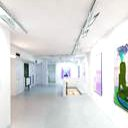

In [10]:
cv2.imread(df['image_full_path'].iloc[0])

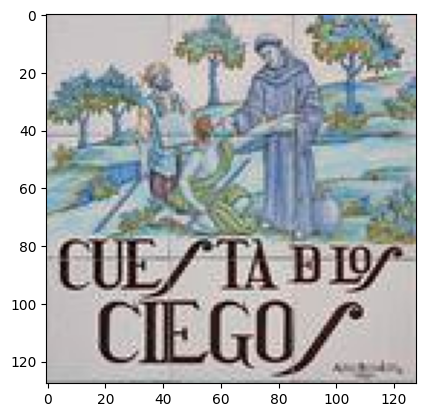

In [ ]:
plt.imshow(cv2.imread(df['image_full_path'].iloc[8]))
plt.show()

### 1.3 Visualizacion de caracteristicas geograficas

In [ ]:
center_lat = df['locationLat'].mean()
center_lon = df['locationLon'].mean()
mapa = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Marcadores para cada POI
for index, row in df.iterrows():
    folium.Marker(
        location=[row['locationLat'], row['locationLon']],
        popup=row['name'],
        icon=folium.Icon(color='blue')
        ).add_to(mapa)


folium.LayerControl().add_to(mapa)
plugins.MiniMap().add_to(mapa)

# Mostrar el mapa
mapa




Output hidden; open in https://colab.research.google.com to view.


---

## 2. Feature Engineering

breve explicacion de porque hacemos este paso

### 2.1 Tratamiento de valores faltantes

* Aunque no tengamos valores nulos, tenemos listas vacias `[]`.*¿Como las gestionamos?*

* La columna categorica de "categories" *¿Como seria mejor codificarla?*



In [ ]:
print(type(df['tags'].iloc[0]))

<class 'str'>


In [ ]:
# Contar cuántas filas tienen tags vacíos: "[]"
empty_tags = df['tags'].apply(lambda x: x.strip() == '[]')
print(f"Número de listas vacías: {empty_tags.sum()}")

Número de listas vacías: 107


In [12]:
df = df[~df['tags'].apply(lambda x: x.strip() == '[]')].reset_index(drop=True)
print("¿Quedan listas vacías?", df['tags'].apply(lambda x: x.strip() == '[]').any())

¿Quedan listas vacías? False


In [13]:
print("Tamaño final del DataFrame:", len(df))

Tamaño final del DataFrame: 1462


In [14]:
df['n_tags']= df['tags'].apply(lambda x: len(x.split(',')))
df['n_tags'].value_counts()

,count
n_tags,
10,473
13,433
1,136
4,102
12,71
5,58
3,56
14,50
6,32


### 2.2 Codificacion de variables categoricas

In [ ]:
# Mostramos algunas estadísticas básicas
print("\nEstadísticas descriptivas:")
metrics = ['Likes', 'Dislikes', 'Visits', 'Bookmarks']
for metric in metrics:
    print(f"\n{metric}:")
    print(f"Media: {df[metric].mean():.2f}")
    print(f"Mediana: {df[metric].median():.2f}")
    print(f"Desviación estándar: {df[metric].std():.2f}")


Estadísticas descriptivas:

Likes:
Media: 3656.30
Mediana: 1651.00
Desviación estándar: 4810.81

Dislikes:
Media: 2524.62
Mediana: 2705.50
Desviación estándar: 2246.86

Visits:
Media: 10011.91
Mediana: 10011.00
Desviación estándar: 5.45

Bookmarks:
Media: 978.09
Mediana: 318.50
Desviación estándar: 1446.54


In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
category_encoded = mlb.fit_transform(df['categories_list'])

# Convertimos a DataFrame
category_df = pd.DataFrame(category_encoded, columns=mlb.classes_)

# Concatenamos al dataset original
df = pd.concat([df, category_df], axis=1)
print(mlb.classes_)

['Arquitectura' 'Ciencia' 'Cine' 'Cultura' 'Escultura' 'Gastronomía'
 'Historia' 'Misterio' 'Naturaleza' 'Ocio' 'Patrimonio' 'Pintura']


In [ ]:
df.head().T

,0,1,2,3,4
id,8a3b45ac-d2bc-4e97-8101-d5af4b40613c,791798a0-f9a8-43de-963d-6b8a5fb18382,2ab0d4c0-b264-4bfe-bdee-2e380cd3fe91,ada425ce-fa30-4d62-abf1-ea968232fea9,77d02f80-bee7-474e-8359-66b5096ee625
name,Hamburguesería Don Oso,"""El Gran Canal desde San Vio, Venecia"", hacia...","""Metrópolis"", 1916-1917, George Grosz","""Quappi con suéter rosa"", 1932 - 1934, Max Bec...","""Retrato de George Dyer en un espejo"", 1968, F..."
shortDescription,"Don Oso, inaugurada en 1973, es un emblema mad...",“El Gran Canal desde San Vio” es una obra maes...,"""Metrópolis"" de George Grosz, una obra impacta...","""Quappi con jersey rosa"" de Max Beckmann es un...","""Retrato de George Dyer en un espejo"" de Franc..."
categories,['Gastronomía'],['Pintura'],['Pintura'],['Pintura'],['Pintura']
tier,3,1,1,1,1
locationLon,-3.716334,-3.694821,-3.695119,-3.694825,-3.694786
locationLat,40.436622,40.416056,40.416275,40.416031,40.416136
tags,['s.XX'],"['Canaletto', 'paisaje', 'vedutismo', 's.XVIII...","['s.XX', 'Primera Guerra Mundial ', 'expresion...","['Cuadro', 's.XX']","['s.XX', 'Cuadro']"
xps,100,500,500,500,500
Visits,10008,10009,10018,10011,10011


In [16]:
# Vamos a extraer los tags individuales y usar los más frecuentes como features binarios.

def convertir_a_lista(cadena):
    try:
        valor = ast.literal_eval(cadena)
        if isinstance(valor, list):
            return valor
        else:
            return [str(valor)]
    except:
        return [str(cadena)]

df['tags_list'] = df['tags'].apply(convertir_a_lista)


In [17]:
from collections import Counter

todos_tags = list(chain.from_iterable(df['tags_list']))
contadores = Counter(todos_tags)

top_tags = [tag for tag, count in contadores.most_common(20)]
print(top_tags)

# generar columnas booleanas
for tag in top_tags:
    df[f'tag_{tag}'] = df['tags_list'].apply(lambda lista: int(tag in lista))


['Historia', 'Madrid', 'Cultura', 'Arquitectura', 'Patrimonio', 'Arte', 'Escultura', 'Estatua', 'Monumento', 'Naturaleza', 'Restauración', 'Grupo escultórico', 'Educación', 'Escultura conceptual o abstracta', 'Centro', 'Retiro', 'Turismo', 'Galicia', 'Homenaje', 'Jerónimos']


In [18]:
#Generar columna de cluesters para variables espaciales
from sklearn.cluster import KMeans

# Seleccionar las columnas de coordenadas
coords = df[['locationLon', 'locationLat']].values

# Definir número de clusters (ejemplo: 5)
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['geo_cluster'] = kmeans.fit_predict(coords)

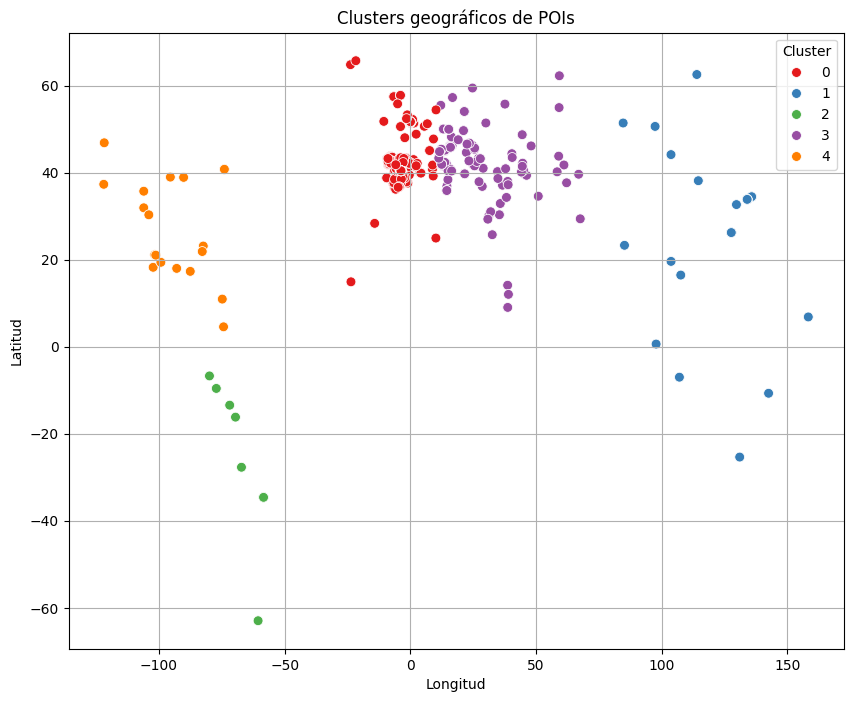

In [ ]:
assert 'locationLon' in df.columns and 'locationLat' in df.columns and 'geo_cluster' in df.columns

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x='locationLon',
    y='locationLat',
    hue='geo_cluster',
    palette='Set1',
    s=50
)
plt.title('Clusters geográficos de POIs')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [ ]:
from folium.plugins import MarkerCluster

# Centrar el mapa en el centro aproximado de Madrid
m = folium.Map(location=[df['locationLat'].mean(), df['locationLon'].mean()], zoom_start=12)

# Definir colores para clusters
cluster_colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightblue']

# Agrupar los puntos en un cluster interactivo
marker_cluster = MarkerCluster().add_to(m)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['locationLat'], row['locationLon']],
        radius=5,
        color=cluster_colors[row['geo_cluster'] % len(cluster_colors)],
        fill=True,
        fill_color=cluster_colors[row['geo_cluster'] % len(cluster_colors)],
        fill_opacity=0.7,
        popup=f"Cluster: {row['geo_cluster']}"
    ).add_to(marker_cluster)

m

### 2.2 Creacion de metricas `Target`

In [19]:
df['engagement_score'] = (
    df['Visits'] +
    df['Likes'] * 2 +  # mayor peso a likes
    df['Bookmarks'] * 1.5 -
    df['Dislikes'] * 1  # penalizar dislikes
)

In [20]:
threshold = df['engagement_score'].median()
df['engagement_label'] = (df['engagement_score'] >= threshold).astype(int)

* 0 = engagement bajo
* 1 = engagement alto

In [22]:
# Comprobar balance de los datos
df['engagement_label'].value_counts(normalize=True)

,proportion
engagement_label,
0,0.5
1,0.5


<Axes: xlabel='engagement_label', ylabel='count'>

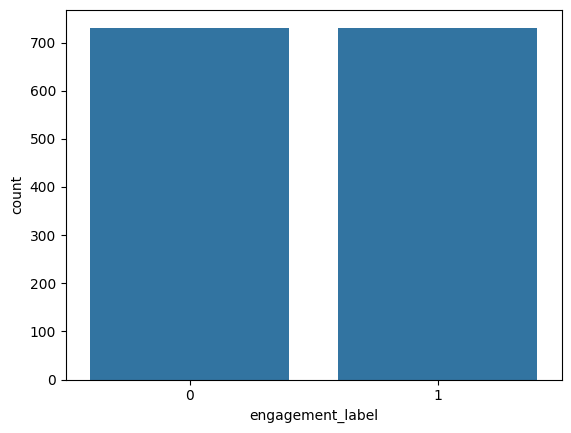

In [ ]:
sns.countplot(data=df, x='engagement_label')

### 2.3 Reduccion de columnas

In [21]:
df.drop(columns=['categories', 'categories_list', 'main_image_path',
                 'name','id','shortDescription','engagement_score',
                 'tags_list', 'n_tags','tags','Visits', 'Likes', 'Dislikes', 'Bookmarks'], inplace=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 39 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tier                                  1462 non-null   int64  
 1   locationLon                           1462 non-null   float64
 2   locationLat                           1462 non-null   float64
 3   xps                                   1462 non-null   int64  
 4   image_full_path                       1462 non-null   object 
 5   Arquitectura                          1462 non-null   int64  
 6   Ciencia                               1462 non-null   int64  
 7   Cine                                  1462 non-null   int64  
 8   Cultura                               1462 non-null   int64  
 9   Escultura                             1462 non-null   int64  
 10  Gastronomía                           1462 non-null   int64  
 11  Historia         

### 2.4 Tratamiento de imagenes

In [25]:
# Calculo de valores de media y desviacion estandar para utilizarlos en la transformacion
image_paths = df['image_full_path'].tolist()

means = []
stds = []

for path in tqdm(image_paths):
    img = Image.open(path).convert('RGB')
    img = transforms.ToTensor()(img)
    means.append(img.mean(dim=(1, 2)))
    stds.append(img.std(dim=(1, 2)))

# Convertimos a tensor para promedio final
mean = torch.stack(means).mean(dim=0)
std = torch.stack(stds).mean(dim=0)

print('Media por canal:', mean)
print('STD por canal:', std)

100%|██████████| 1462/1462 [15:56<00:00,  1.53it/s]

Media por canal: tensor([0.4451, 0.4412, 0.4202])
STD por canal: tensor([0.1908, 0.1909, 0.2015])


In [26]:
df.head().T

,0,1,2,3,4
tier,3,1,1,1,1
locationLon,-3.716334,-3.694821,-3.695119,-3.694825,-3.694786
locationLat,40.436622,40.416056,40.416275,40.416031,40.416136
xps,100,500,500,500,500
image_full_path,/content/drive/MyDrive/Deep Learning/Proyecto/...,/content/drive/MyDrive/Deep Learning/Proyecto/...,/content/drive/MyDrive/Deep Learning/Proyecto/...,/content/drive/MyDrive/Deep Learning/Proyecto/...,/content/drive/MyDrive/Deep Learning/Proyecto/...
Arquitectura,0,0,0,0,0
Ciencia,0,0,0,0,0
Cine,0,0,0,0,0
Cultura,0,0,0,0,0
Escultura,0,0,0,0,0


### 2.4 Division del conjunto de datos

* Entrenamiento (70%)
* Validación (15%)
* Prueba (15%)




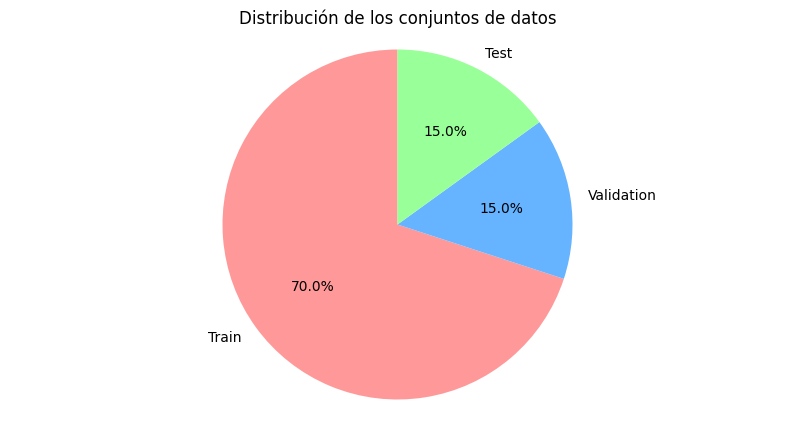

In [23]:

#Division
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['engagement_label'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['engagement_label'])

# Creamos un pie plot para visualizar la distribución de los conjuntos de datos
def display_split_pie_chart(df_train, df_val,df_test):
    """
    Función que muestra un gráfico de pie que representa la distribución
    de los conjuntos de datos (train, validation y test)
    """
    plt.figure(figsize=(10, 5))
    sizes = [df_train.shape[0], df_val.shape[0], df_test.shape[0]]
    labels = ['Train', 'Validation', 'Test']
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Distribución de los conjuntos de datos')
    plt.show()

display_split_pie_chart(df_train, df_val,df_test)


---

# 3. *Modelo Multimodal*

1. *CNN - Red de neuronas convolucionales*
2. *Red neuronal para metadatos*
3. *Fusion de modalidades*

### 3.1 Normalizacion y transformacion de variables, creacion de DataSets y DataLoader

In [24]:
# Normalizacion datos geograficos solo a train
scaler = StandardScaler()
scaler.fit(df_train[['locationLon', 'locationLat']])

# Transformar todos los conjuntos
df_train[['locationLon', 'locationLat']] = scaler.transform(df_train[['locationLon', 'locationLat']])
df_val[['locationLon', 'locationLat']] = scaler.transform(df_val[['locationLon', 'locationLat']])
df_test[['locationLon', 'locationLat']] = scaler.transform(df_test[['locationLon', 'locationLat']])


In [25]:
# Definimos las transformaciones para entrenamiento (con data augmentation)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4451, 0.4412, 0.4202], std=[0.1908, 0.1909, 0.2015])
])


# Definimos transformaciones para validación y test (solo normalización)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4451, 0.4412, 0.4202], std=[0.1908, 0.1909, 0.2015])
    ])

In [26]:
# Crear clase que cargue y procese imagenes y metadatos para cada POI en el futuro modelo
class POIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

        # Usamos todas las columnas numéricas como metadatos (excepto imagen y etiquetas)
        self.metadata_cols = [
            col for col in dataframe.columns
            if col not in ['image_full_path', 'engagement_score', 'engagement_label']
        ]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Cargar y transformar imagen
        img_path = row['image_full_path']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Procesar metadatos
        metadata_vals = row[self.metadata_cols].values.astype(np.float32)
        metadata = torch.tensor(metadata_vals, dtype=torch.float32)

        # Etiqueta binaria: 0 o 1
        label = torch.tensor(row['engagement_label'], dtype=torch.long)

        return image, metadata, label

In [27]:
# Crear Dataset y Dataloaders
train_dataset = POIDataset(df_train, transform=transform_train)
val_dataset = POIDataset(df_val, transform=transform_test)
test_dataset = POIDataset(df_test, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Imprimir tamaños de los datasets
print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de validación: {len(val_dataset)}")
print(f"Tamaño del conjunto de test: {len(test_dataset)}")

Tamaño del conjunto de entrenamiento: 1023
Tamaño del conjunto de validación: 219
Tamaño del conjunto de test: 220


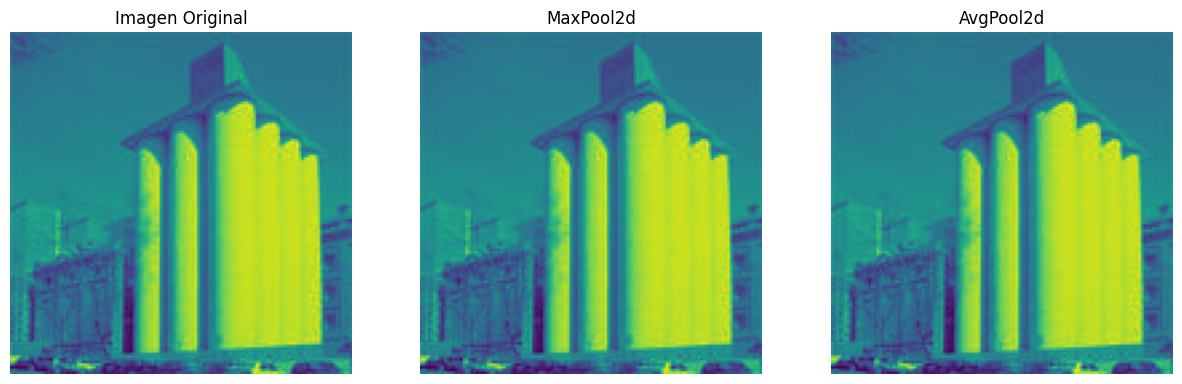

Tamaño original: torch.Size([1, 1, 128, 128])
MaxPool: torch.Size([1, 1, 64, 64])
AvgPool: torch.Size([1, 1, 64, 64])


In [32]:
# Visualizacion con pooling
img_path = df['image_full_path'].iloc[100]
image = Image.open(img_path).convert('L')

transform = transforms.Compose([
    transforms.ToTensor(),
])

x = transform(image).unsqueeze(0)  # Añadir dimensión batch

# Pooling
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)

max_output = max_pool(x)
avg_output = avg_pool(x)

# Visualización
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(x[0].permute(1, 2, 0).numpy())
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(x[0].permute(1, 2, 0).numpy())
plt.title('MaxPool2d')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(x[0].permute(1, 2, 0).numpy())
plt.title('AvgPool2d')
plt.axis('off')

plt.show()

# Tamaños
print(f"Tamaño original: {x.shape}")
print(f"MaxPool: {max_output.shape}")
print(f"AvgPool: {avg_output.shape}")

### 3.2 Creacion de CNN

In [28]:
# Red Convolucional para imágenes
class VisualCNN(nn.Module):
    def __init__(self):
        super(VisualCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 16 * 16, 256)  # 128x128 que es la salida de la ultima capa

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


In [30]:
# Red Tabular
class TabularNN(nn.Module):
    def __init__(self, input_dim):
        super(TabularNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

    def forward(self, x):
        return self.net(x)


In [31]:
# Fusion multimodal
class MultimodalNet(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalNet, self).__init__()
        self.visual_net = VisualCNN()
        self.tabular_net = TabularNN(input_dim)
        self.classifier = nn.Sequential(
            nn.Linear(256 + 32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # salida binaria
        )

    def forward(self, image, tabular):
        image_features = self.visual_net(image)
        tabular_features = self.tabular_net(tabular)
        combined = torch.cat((image_features, tabular_features), dim=1)
        return self.classifier(combined).squeeze(1)  # [B,1] → [B]


---

# 4. *Entrenamiento y evaluacion*

In [32]:
#funcion de entrenamiento por epoch
def train_epoch(model, device, dataloader, criterion, optimizer):
    model.train()
    running_loss, running_corrects = 0.0, 0

    for images, metadata, labels in dataloader:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images, metadata).squeeze(1)  # [B,1] → [B]
        loss = criterion(outputs, labels)

        preds = (torch.sigmoid(outputs) > 0.5).float()
        running_corrects += (preds == labels).sum().item()
        running_loss += loss.item() * labels.size(0)

        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc



In [33]:
# Función de evaluación por epoch
def eval_epoch(model, device, dataloader, criterion):
    model.eval()
    running_loss, running_corrects = 0.0, 0

    with torch.no_grad():
        for images, metadata, labels in dataloader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device).float()

            outputs = model(images, metadata).squeeze(1)
            loss = criterion(outputs, labels)

            preds = (torch.sigmoid(outputs) > 0.5).float()
            running_corrects += (preds == labels).sum().item()
            running_loss += loss.item() * labels.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc


In [34]:

def test_model(model, test_loader, device):
    criterion = nn.BCEWithLogitsLoss()
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, metadata, labels in test_loader:
            images, metadata = images.to(device), metadata.to(device)
            outputs = model(images, metadata)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    print(f"\n📊 Test Report (Bajo vs. Alto Engagement):")
    print(classification_report(all_labels, all_preds, target_names=["Bajo", "Alto"]))


In [35]:
def eval_model(model, dataloader, criterion, device):
    model.eval()
    eval_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, metadata, labels in dataloader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.float().to(device)

            outputs = model(images, metadata)
            loss = criterion(outputs, labels)

            eval_loss += loss.item() * labels.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = eval_loss / total
    accuracy = correct / total

    return avg_loss, accuracy, all_preds, all_labels


In [36]:
def train_model(model, train_loader, val_loader, num_epochs, lr, device):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for images, metadata, labels in train_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        val_loss, val_acc, _, _ = eval_model(model, val_loader, criterion, device)

        train_epoch_loss = train_loss / total
        train_epoch_acc = correct / total

        history['train_loss'].append(train_epoch_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_epoch_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history


In [51]:
input_dim = len(train_dataset.metadata_cols)  # cantidad de features tabulares
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [52]:
model = MultimodalNet(input_dim=input_dim)

In [53]:
train_model(model, train_loader, val_loader, num_epochs=15, lr=0.001, device=device)
test_model(model, test_loader, device)

Epoch 1/15 | Train Loss: 0.7433, Train Acc: 0.5415 | Val Loss: 0.6661, Val Acc: 0.5982
Epoch 2/15 | Train Loss: 0.6948, Train Acc: 0.5865 | Val Loss: 0.6550, Val Acc: 0.5890
Epoch 3/15 | Train Loss: 0.6319, Train Acc: 0.6452 | Val Loss: 0.6341, Val Acc: 0.6027
Epoch 4/15 | Train Loss: 0.6180, Train Acc: 0.6588 | Val Loss: 0.6027, Val Acc: 0.7032
Epoch 5/15 | Train Loss: 0.5648, Train Acc: 0.7165 | Val Loss: 0.5749, Val Acc: 0.7215
Epoch 6/15 | Train Loss: 0.5380, Train Acc: 0.7283 | Val Loss: 0.5503, Val Acc: 0.7991
Epoch 7/15 | Train Loss: 0.5342, Train Acc: 0.7302 | Val Loss: 0.5310, Val Acc: 0.8082
Epoch 8/15 | Train Loss: 0.5233, Train Acc: 0.7605 | Val Loss: 0.5679, Val Acc: 0.7489
Epoch 9/15 | Train Loss: 0.5079, Train Acc: 0.7683 | Val Loss: 0.5545, Val Acc: 0.7580
Epoch 10/15 | Train Loss: 0.4996, Train Acc: 0.7615 | Val Loss: 0.5616, Val Acc: 0.7945
Epoch 11/15 | Train Loss: 0.4729, Train Acc: 0.7752 | Val Loss: 0.5324, Val Acc: 0.7854
Epoch 12/15 | Train Loss: 0.4683, Train A

In [50]:
model = MultimodalNet(input_dim=df_train.shape[1] - 2)
train_model(model, train_loader, val_loader, num_epochs=15, lr=1e-4, device=device)
test_model(model, test_loader, device)

Epoch 1/15 | Train Loss: 0.7030, Train Acc: 0.5318 | Val Loss: 0.6486, Val Acc: 0.5479
Epoch 2/15 | Train Loss: 0.6474, Train Acc: 0.6285 | Val Loss: 0.5917, Val Acc: 0.6712
Epoch 3/15 | Train Loss: 0.5947, Train Acc: 0.6891 | Val Loss: 0.5647, Val Acc: 0.7352
Epoch 4/15 | Train Loss: 0.5938, Train Acc: 0.6921 | Val Loss: 0.5525, Val Acc: 0.7169
Epoch 5/15 | Train Loss: 0.5649, Train Acc: 0.7126 | Val Loss: 0.5763, Val Acc: 0.7078
Epoch 6/15 | Train Loss: 0.5541, Train Acc: 0.7322 | Val Loss: 0.5297, Val Acc: 0.7763
Epoch 7/15 | Train Loss: 0.5266, Train Acc: 0.7302 | Val Loss: 0.5299, Val Acc: 0.7671
Epoch 8/15 | Train Loss: 0.5178, Train Acc: 0.7439 | Val Loss: 0.5404, Val Acc: 0.7443
Epoch 9/15 | Train Loss: 0.4926, Train Acc: 0.7644 | Val Loss: 0.5134, Val Acc: 0.7808
Epoch 10/15 | Train Loss: 0.5001, Train Acc: 0.7429 | Val Loss: 0.5268, Val Acc: 0.7671
Epoch 11/15 | Train Loss: 0.4907, Train Acc: 0.7703 | Val Loss: 0.5338, Val Acc: 0.7854
Epoch 12/15 | Train Loss: 0.4775, Train A

# 5. Visualizar

In [42]:
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/15 | Train Loss: 0.4515, Train Acc: 0.7967 | Val Loss: 0.5295, Val Acc: 0.7763
Epoch 2/15 | Train Loss: 0.4496, Train Acc: 0.8113 | Val Loss: 0.5298, Val Acc: 0.7763
Epoch 3/15 | Train Loss: 0.4333, Train Acc: 0.8104 | Val Loss: 0.5264, Val Acc: 0.7854
Epoch 4/15 | Train Loss: 0.4231, Train Acc: 0.8123 | Val Loss: 0.5314, Val Acc: 0.7763
Epoch 5/15 | Train Loss: 0.4054, Train Acc: 0.8143 | Val Loss: 0.5407, Val Acc: 0.7763
Epoch 6/15 | Train Loss: 0.4169, Train Acc: 0.8221 | Val Loss: 0.5447, Val Acc: 0.7854
Epoch 7/15 | Train Loss: 0.4182, Train Acc: 0.8113 | Val Loss: 0.5489, Val Acc: 0.7260
Epoch 8/15 | Train Loss: 0.4113, Train Acc: 0.8221 | Val Loss: 0.5481, Val Acc: 0.7763
Epoch 9/15 | Train Loss: 0.3956, Train Acc: 0.8211 | Val Loss: 0.5664, Val Acc: 0.7626
Epoch 10/15 | Train Loss: 0.4030, Train Acc: 0.8152 | Val Loss: 0.5519, Val Acc: 0.7763
Epoch 11/15 | Train Loss: 0.3919, Train Acc: 0.8240 | Val Loss: 0.5580, Val Acc: 0.7626
Epoch 12/15 | Train Loss: 0.4145, Train A

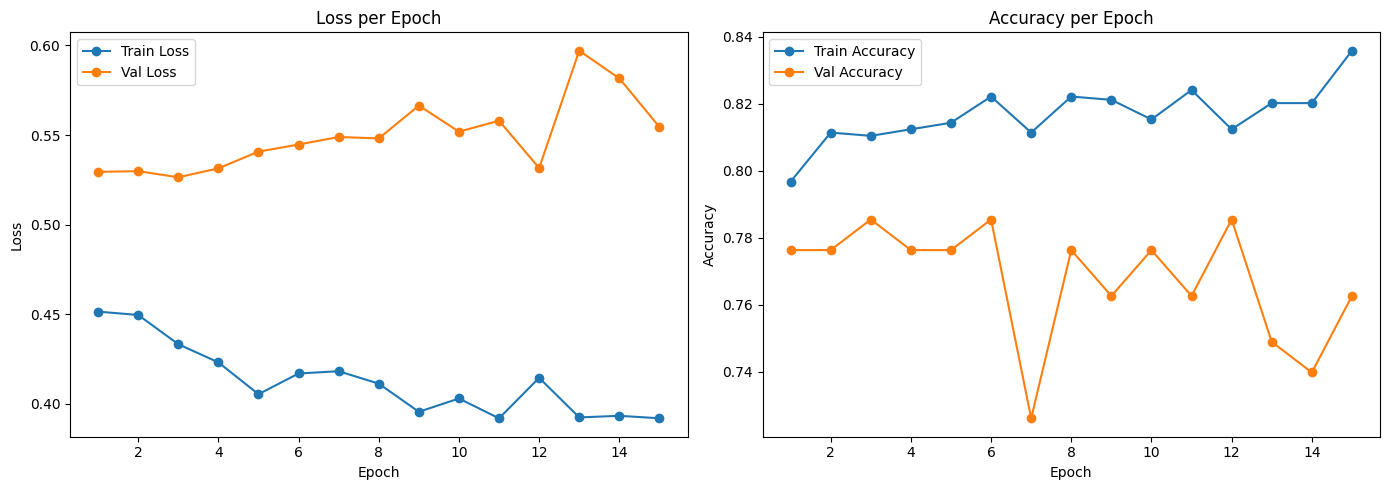

In [43]:
model.to(device)
history = train_model(model, train_loader, val_loader, num_epochs=15, lr=1e-4, device=device)
plot_training_curves(history)

In [55]:
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, num_epochs=20, lr=0.0001, device=device)
test_model(model, test_loader, device)

Epoch 1/20 | Train Loss: 0.4240, Train Acc: 0.8035 | Val Loss: 0.5280, Val Acc: 0.7991
Epoch 2/20 | Train Loss: 0.4025, Train Acc: 0.8240 | Val Loss: 0.5272, Val Acc: 0.8174
Epoch 3/20 | Train Loss: 0.4048, Train Acc: 0.8172 | Val Loss: 0.5362, Val Acc: 0.8037
Epoch 4/20 | Train Loss: 0.3846, Train Acc: 0.8446 | Val Loss: 0.5321, Val Acc: 0.8128
Epoch 5/20 | Train Loss: 0.3930, Train Acc: 0.8299 | Val Loss: 0.5410, Val Acc: 0.8128
Epoch 6/20 | Train Loss: 0.3884, Train Acc: 0.8338 | Val Loss: 0.5311, Val Acc: 0.8311
Epoch 7/20 | Train Loss: 0.3799, Train Acc: 0.8299 | Val Loss: 0.5382, Val Acc: 0.8082
Epoch 8/20 | Train Loss: 0.3772, Train Acc: 0.8465 | Val Loss: 0.5388, Val Acc: 0.8128
Epoch 9/20 | Train Loss: 0.3874, Train Acc: 0.8397 | Val Loss: 0.5295, Val Acc: 0.8356
Epoch 10/20 | Train Loss: 0.3690, Train Acc: 0.8338 | Val Loss: 0.5357, Val Acc: 0.8311
Epoch 11/20 | Train Loss: 0.3566, Train Acc: 0.8397 | Val Loss: 0.5292, Val Acc: 0.8311
Epoch 12/20 | Train Loss: 0.3661, Train A